In [5]:
from qiskit import *
from qiskit import Aer, execute
from qiskit.circuit.library import RealAmplitudes, TwoLocal
from qiskit_ibm_runtime import QiskitRuntimeService, Options, Session, Sampler
from qiskit.providers.fake_provider import FakeManila
from qiskit_aer.noise import NoiseModel
import numpy as np
from sklearn import *
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC 
import matplotlib.pyplot as plt
from qiskit.visualization import plot_histogram

In [6]:
def data_append(n, x1, x2):
    para_data = []
    for i in range(n):
        for j in range(n):
            if i<j:
                para_data.append(list(x1[i])+list(x2[j]))
    return para_data

img = np.load('data/images.npy')
lbl = np.load('data/labels.npy')
img3 = []
for ii in range(len(img)):
    img2 = img[ii].flatten()
    img3.append(img2)

def plot_matrix(A, title):
    """plots a given matrix."""
    # plot matrix
    plt.title(title)
    ax = plt.imshow(A, cmap='viridis')
    plt.colorbar(ax)
    plt.tight_layout()
    plt.show()
    
def process_samples(circuit, samples):
    """maps dictionary of (quasi-) probabilities to dense vector for illustration.
       (scales exponentially! don't apply to too many qubits!."""
    probs = np.zeros(2**circuit.num_qubits)
    for b, p in samples.quasi_dists[0].items():
        probs[b] = p
    return probs
def plot_probabilities(circuit, probs, label):
    """plots probability vector."""
    x = np.array(range(2**circuit.num_qubits))
    fig, ax = plt.subplots()
    ax.bar(x, probs, align='center', alpha=1, label=label)
    ax.set_title('Probabilities')
    ax.yaxis.grid(True)
    ax.xaxis.set_major_formatter(lambda x, pos: f'{int(x):0{circuit.num_qubits}b}')
    plt.xticks(x[::4], rotation=90)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_cumulative_probabilities(circuit, probs_list, labels):
    """plots multiple cumulative probabilities."""
    x = np.array(range(2**circuit.num_qubits))
    fig, ax = plt.subplots()
    for i, probs in enumerate(probs_list):
        ax.plot(x, np.cumsum(probs), label=labels[i], linewidth=2)
    ax.set_title('Cumulative Probabilities')
    ax.yaxis.grid(True)
    ax.xaxis.set_major_formatter(lambda x, pos: f'{int(x):0{circuit.num_qubits}b}')
    plt.xticks(x[::4], rotation=90)
    plt.legend()
    plt.tight_layout()
    plt.show()
    


In [7]:
# split dataset
sample_train, sample_test, labels_train, labels_test = train_test_split(
     img3, lbl, test_size=0.7, random_state=22)

# reduce dimensions
n_dim = 8
pca = PCA(n_components=n_dim).fit(sample_train)
sample_train = pca.transform(sample_train)
sample_test = pca.transform(sample_test)

# standardize
std_scale = StandardScaler().fit(sample_train)
sample_train = std_scale.transform(sample_train)
sample_test = std_scale.transform(sample_test)

# Normalize
samples = np.append(sample_train, sample_test, axis=0)
minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
sample_train = minmax_scale.transform(sample_train)
sample_test = minmax_scale.transform(sample_test)

# select 25 set of data for learning and 10 for test 
train_size = 25
sample_train = sample_train[:train_size]
labels_train = labels_train[:train_size]

test_size = 10
sample_test = sample_test[:test_size]
labels_test = labels_test[:test_size]


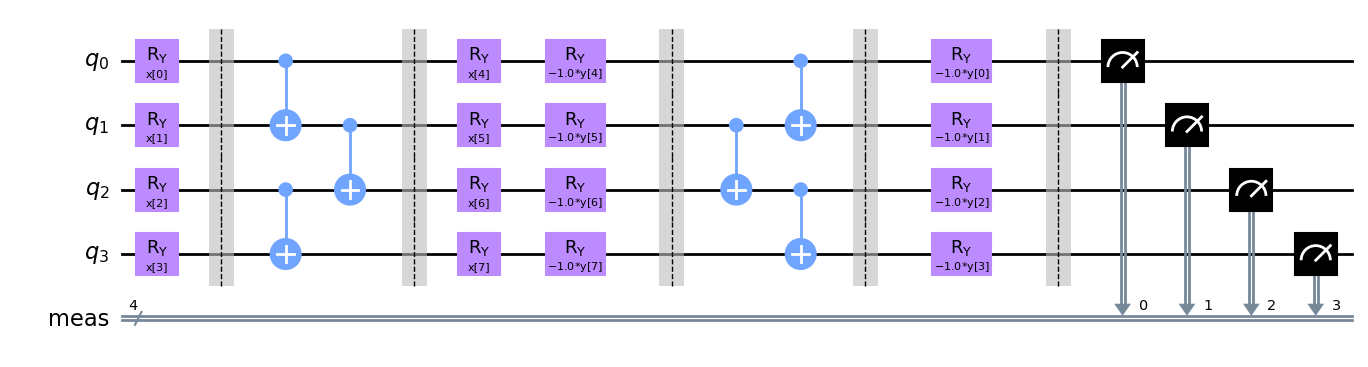

In [8]:
# parametrized circuit defining U first state
circuit_1 = RealAmplitudes(4, reps=1, entanglement='pairwise', 
                           insert_barriers=True, parameter_prefix='x')
    
# parametrized circuit V defining second state
circuit_2 = RealAmplitudes(4, reps=1, entanglement='pairwise', 
                           insert_barriers=True, parameter_prefix='y')

# combining circuits to evaluate U^dagger V
fidelity_circuit = circuit_1.copy()
fidelity_circuit.append(circuit_2.inverse().decompose(), range(fidelity_circuit.num_qubits))
fidelity_circuit.measure_all()

# drawing resulting circuit to estimate fidelity
fidelity_circuit.decompose().draw('mpl')

In [9]:
n = 25
circuit_num = np.arange(0,n).sum()
k = data_append(n, sample_train, sample_train)

In [10]:

fake_backend = FakeManila()
noise_model = NoiseModel.from_backend(fake_backend)
options_noise = Options(
    simulator={
        "noise_model": noise_model,
        "seed_simulator": 1234
    },
    resilience_level=1
)

# authenticate at Qiskit runtime service
service = QiskitRuntimeService()
# choose a cloud simulator
backend = service.backends(simulator=True)[0]

with Session(service=service, backend=backend):
    sampler = Sampler(options=options_noise)
    job =  sampler.run(circuits=[fidelity_circuit]*len(k), parameter_values=k , shots=10000)
    quantum_kernel_em = job.result()

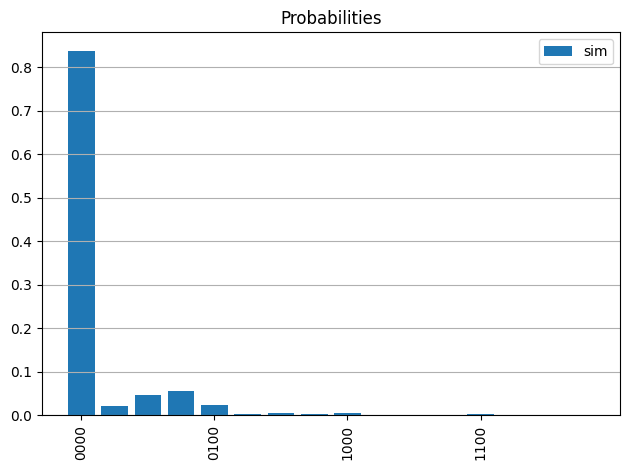

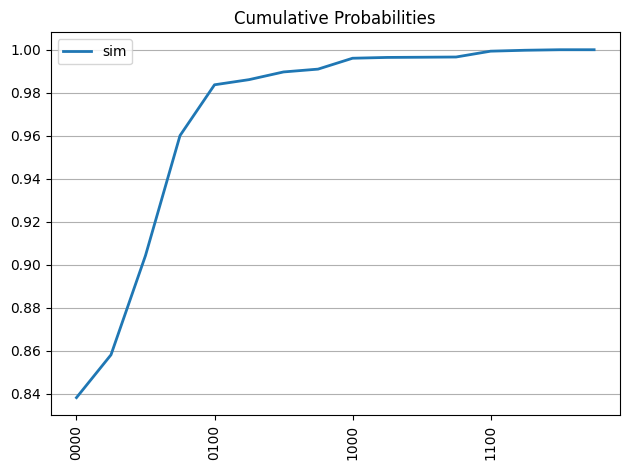

In [11]:
probs_sim = process_samples(fidelity_circuit, quantum_kernel_em)
plot_probabilities(fidelity_circuit, probs_sim, 'sim')
plot_cumulative_probabilities(fidelity_circuit, [probs_sim], ['sim'])

In [12]:
kernel_em = []
for i in range(circuit_num):
    kernel_em += [quantum_kernel_em.quasi_dists[i][0]]

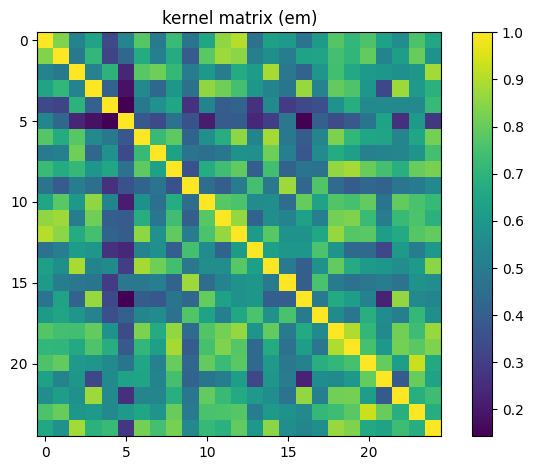

In [13]:
K = np.zeros((n, n))
count = 0
for i in range(n):
    for j in range(n):
        if j<i:
            K[i,j] = K[j,i]
        else:
            if j==i:
                K[i,j] = 1
            else:
                K[i,j] = kernel_em[count]
                count+=1
plot_matrix(K, 'kernel matrix (em)')

In [14]:
svc = SVC(kernel='precomputed')
# train SVM
svc.fit(K, labels_train)

# score SVM on training data
y_predict = svc.predict(K)
print('accuracy (sim):', sum(y_predict == labels_train)/len(labels_train))

accuracy (sim): 0.84


In [15]:
print(labels_train, y_predict)

[False False False  True  True  True False False  True False False  True
 False False False False  True False  True  True False False  True False
 False] [False False False  True  True False False False False False False False
 False False False False  True False False  True False False  True False
 False]
